# O Problema do Caixeiro Viajante com o Programação Linear e o Método DFJ

<p> Autor: <a href="https://www.linkedin.com/in/vinicius-aquino-in/"  target="_blank" rel="noopener noreferrer">Vinicius Aquino</a></p>
<p>Data: 01/09/2024</p>

## Resumo

O texto se propõe a discutir o problema do Caixeiro Viajante no contexto de Programação Linear usando a biblioteca gurobipy. Foram usado os dados de localização dos estádios da Série A do campeaonto brasileiro para a análise e o método DFJ para a eliminação de subrotas.

## O Problema do Caixeiro Viajante

O problema do caixeiro viajante (ou Traveling Salesman) é o problema onde temos um indíviduo que deseja visitar $n$ cidades de forma que visite cada cidade somente uma vez e volte na sua origem percorrendo a menor distância possível. É um problema clássico da otimização devido à sua velocidade de aumento de complexidade computacional. Quando temos somente $4$ cidades, por exemplo, há somente $3$ possibilidades de rotas. Todavia, esse espaço de possibildades cresce de forma exponencial conforme $n$ cresce. Sendo $S$ o espaço de busca da melhor rota, então o tamanho de $S$ é dado por: 
$$C_{n, 2} = \frac{(n-1)!}{2}$$

No caso, usando os 19 estádios da Série A do Brasileirão 2024, temos 3.201.186.852.864.000 (três quadrilhões, duzentos e um trilhões, cento e oitenta e seis bilhões, oitocentos e cinquenta e 2 milhões, oitocentos e secenta e quatro mil) possibilidades de rota. Nesse caso, você já pode imaginar que, por mais trivial que seja o cálculo da distância total dessa rota, é impossível testar todas as possibilidades, o que nos exige uma forma robusta de encontrar a solução ótima.

Apesar de parecer um problema abstrato, não faltam aplicações desse problema na "vida real". Por exemplo, no contexto de logística, um caminhão que saí de um hub para abastecer uma rede de suprimento vai passar por todos os pontos e, por fim, voltar para o seu hub. Nesse caso, a definição da sua rota pode ser encarada como um Problema do Caixeiro Viajante.

## A Abordagem da Programação Linear

O último parágrafo pode ter te assutado, afinal, todas as vezes que um entregador da Amazon saí com 20 pacotes para entregar, ele tem que pensar em qual das dezenas de quadrilhões de rotas ele deve seguir durante o seu dia. Mas calma, há formas de se resolver esse problema. No caso, o approach a ser implementado será o da Programação Linear (PL). Não é minha intenção ensinar como "pensa" a abordagem da programação linear, porque isso tornaria o texto excessivamente extenso. Todavia, o que você precisa entender é que em um problema de Programação Linear temos variáveis de decisão, que é o que queremos otimizar, uma função objetivo linear e restrições lineares. 

## Resolvendo O Problema do Caixeiro Viajante para os Estádios da Série A do Brasileirão 2024

### Definindo o Problema:

O primeiro passo para resolver um problema de Programação Linear é definir quem serão nossas variáveis. No caso, defineremos $x_{ij}$ como uma variável binária de decisão que define se o nosso caixeiro viajante sairá do estádio $i$ para o estádio $j$ (algo como: quando estivermos no Morumbi, vamos para o Maracanã? Ou quem sabe o Mineirão?):


<b>$x_{ij}$ -> Se, ao estar no estádio $i$, o caixeiro seguirá para o estádio $j$ </b><br>

Outra variável importante é o custo $c_{ij}$ de ir do estádio i para o estádio j (algo como: afinal, qual o custo de tomar a decisão de ir do Morumbi para o Maracanã?):

<b>$c_{ij}$ -> Custo de, ao estar no estádio $i$, seguir para o estádio $j$ </b><br>

Repare na palavra custo. Ela não está aí a toa. No nosso caso, o custo vai ser a distância. Mais precisamente a distância euclidiana das latitudes e longitudes dos estádios. Poderia ser o tempo, por exemplo. Poderia ser um custo financeiro ou ambiental (emissão de carbono). <br>

Definida, então, essas variáveis, já podemos partir para a função objetivo, que é quem minimizaremos:

$$\text{Minimizar} \quad Z = \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} \cdot x_{ij}$$

Não se assuste. Nossa função objetivo basicamente diz que custo total (que desejamos minimizar) será algo como:

(custo de ir do Morumbi para o Maracanã) * (decisão de ir do Morumbi para o Maracanã) + (custo de ir do Morumbi para o Mineirão) * (decisão de ir do Morumbi para o Maracanã) + ... + (custo de ir do Maracanã para o Morumbi) * (decisão de ir do Maracanã para o Mineirão) + ...

A maior parte dessas variáveis de decisões vão ter valor 0, afinal, nossa rota tem 19 estádios.

Além disso, devemos adicionar algumas regras para o modelo não encontrar uma solução que não faz sentido para o nosso problema, por exemplo: o caixeiro não pode ficar no mesmo lugar. Então:

$x_{ii} = 0$, para i = 1, 2, 3, ... n

Além disso, ele tem que visitar todos os pontos:

$\sum_{i=1}^{n} x_{ij} = 1$, para j = 1, 2, 3, ... n

Isso é algo como: Eu tenho que ir para o Morumbi, seja pelo Maracanã, seja pelo Mineirão, seja pelo Castelão...


$\sum_{j=1}^{n} x_{ij} = 1$ , para i = 1, 2, 3, ... n

Isso é algo como: A partir do Morumbi eu tenho que ir ou para o Maracanã, ou do Mineirão, ou do Castelão... Não posso sair de um lugar para dois ou mais.

Deixando o nosso problema de PL na forma padrão:

$\text{Minimizar} \quad Z = \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} \cdot x_{ij}$

sa:

$x_{ii} = 0$ <br>
$\sum_{i=1}^{n} x_{ij} = 1$ <br>
$\sum_{j=1}^{n} x_{ij} = 1$ <br>

Sendo $x_{ij}$ variáveis binárias.

### Implementando com Python e Gurobi

Pacotes a serem usados:

In [203]:
# Manipular dados
import pandas as pd
import geopandas as gpd

# Otimização
import gurobipy as gp
from gurobipy import GRB

# Utils
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

plt.style.use("ggplot")

Importando dados e plotando vizualização dos pontos:

In [204]:
geo_plot = gpd.read_file("bcim_2016_21_11_2018.gpkg", layer="lim_unidade_federacao_a")
df = pd.read_csv("estadios_data.csv")

df.head()

,estadio,latitude,longitude,clube
0,Maracanã,-22.912,-43.230,Flamengo/ Fluminense
1,Morumbis,-23.600,-46.719,São Paulo
2,Mineirão,-19.866,-43.971,Cruzeiro
3,Arena Grêmio,-30.022,-51.213,Grêmio
4,Castelão,-3.826,-38.539,Fortaleza


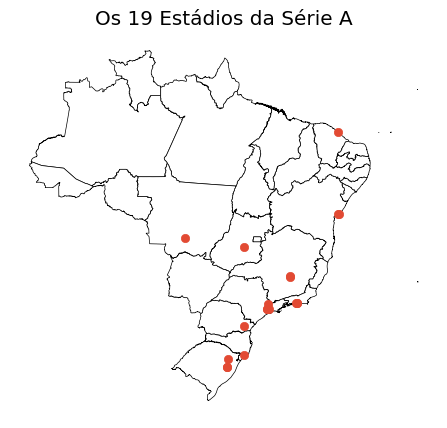

In [205]:
f, ax = plt.subplots(figsize=(8, 5))

ax.set_axis_off()
geo_plot.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(df.longitude, df.latitude)

plt.title("Os 19 Estádios da Série A")
plt.show()

Calculando distancias (a variável $c_{ij}$):

In [206]:
df_distancia = pd.DataFrame(distance_matrix(df[["latitude", "longitude"]].values,
                                            df[["latitude", "longitude"]].values),
                            index=df.estadio,columns=df.estadio)

df_distancia.iloc[:8, :8]

estadio,Maracanã,Morumbis,Mineirão,Arena Grêmio,Castelão,Beira-Rio,Neo-Quimica Arena,Arena Fonte Nova
estadio,,,,,,,,
Maracanã,0.000000,3.556187,3.134836,10.690201,19.654030,10.735988,3.305182,10.999980
Morumbis,3.556187,0.000000,4.636190,7.838247,21.399147,7.886667,0.251098,13.427281
Mineirão,3.134836,4.636190,0.000000,12.473608,16.934823,12.521974,4.449725,8.793114
Arena Grêmio,10.690201,7.838247,12.473608,0.000000,29.100871,0.048765,8.025562,21.259881
Castelão,19.654030,21.399147,16.934823,29.100871,0.000000,29.149596,21.255662,9.153067
Beira-Rio,10.735988,7.886667,12.521974,0.048765,29.149596,0.000000,8.073849,21.308102
Neo-Quimica Arena,3.305182,0.251098,4.449725,8.025562,21.255662,8.073849,0.000000,13.234850
Arena Fonte Nova,10.999980,13.427281,8.793114,21.259881,9.153067,21.308102,13.234850,0.000000


Nesse caso, criamos uma matrix 19 x 19 onde o elemento da linha i e da coluna j é a distância entre i e j. Nesse caso, haverá uma matriz 19 x 19 de variáveis de decisão binária, onde cada elemento da linha i e da coluna j representa a decisão de tomar o custo desta matriz.

Definindo o modelo e otimizando:

In [207]:
model = gp.Model("tsp_v1")
model.Params.LogToConsole = 0

n = len(df_distancia)
# A dita matrix 19x19
x = model.addVars(n, n, vtype=GRB.BINARY, name="x")

# Definindo a função objetivo, no caso multiplicando as variáveis de decisão pelas distâncias do nosso dataset
model.setObjective(gp.quicksum(df_distancia.iloc[i,j] * x[i, j] for i in range(n) for j in range(n)), gp.GRB.MINIMIZE)

# Definindo restrições:

# Garante que o caixeiro vai se movimentar de um ponto para outro
for i in range(n):
    model.addConstr(gp.quicksum(x[i, j] for j in range(n)) == 1)

# Garante que partindo de um ponto, o caxeiro só chegará em outro ponto
for j in range(n):     
    model.addConstr(gp.quicksum(x[i, j] for i in range(n)) == 1)

# Garante que não ficará no mesmo lugar (o custo é zero, o que é bem tentador)
for i in range(n):     
    model.addConstr(x[i, i] == 0)

# Otimiza!
model.optimize()

Nesse caso, as variáveis de decisão foram:

In [208]:
rota = [(i, j) for i in range(n) for j in range(n) if x[i, j].x == 1]

for i, j in rota: 
    print(f"{df.iloc[i, 0]} -> {df.iloc[j, 0]}")

Maracanã -> Nilton Santos
Morumbis -> Allianz Arena
Mineirão -> Arena MRV
Arena Grêmio -> Alfredo Jaconi
Castelão -> Arena Fonte Nova
Beira-Rio -> Arena Grêmio
Neo-Quimica Arena -> Arena Red bull
Arena Fonte Nova -> Barradão
Nilton Santos -> São Januário
Arena MRV -> Mineirão
Allianz Arena -> Morumbis
Arena Pantanal -> Antonio Accioly
Ligga Arena -> Majestoso
Barradão -> Castelão
São Januário -> Maracanã
Alfredo Jaconi -> Beira-Rio
Majestoso -> Ligga Arena
Arena Red bull -> Neo-Quimica Arena
Antonio Accioly -> Arena Pantanal


Plotando a rota:

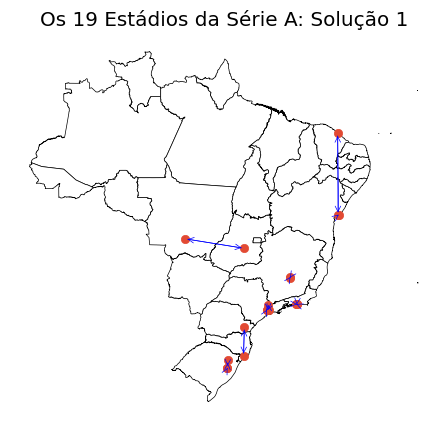

In [209]:
f, ax = plt.subplots(figsize=(8, 5))

ax.set_axis_off()
geo_plot.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(df.longitude, df.latitude)

arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in rota:
    plt.annotate("", xy=[ df.iloc[j]['longitude'], df.iloc[j]['latitude']],\
                      xytext=[ df.iloc[i]['longitude'], df.iloc[i]['latitude']],\
                     arrowprops=arrowprops)
    
plt.title("Os 19 Estádios da Série A: Solução 1")
plt.show()

Faz sentido?

Matemáticamente, sim. De fato, o modelo definiu rotas de forma que todos os estádios tiveram somente um destino e vieram somente de uma origem. Foi basicamente isso que exigimos dele. Ele basicamente sugeriu: faça vários tours diferentes em cada estado e, caso não seja possível (isso é, tenha somente um estádio no estado), vá para o estádio solitário mais próximo.

Foi o que ele fez sugerindo Ligga Arena -> Majestoso, Castelão -> Arena Fonte Nova e Arena Pantanal -> Antonio Accioly.

Isso acontece porque não exigimos do modelo que todas as rotas estejam conectadas, apenas que ele passe por cada estádio e não deixe nenhum estádio isolado. Entendido isso, já posso dizer que você está apresentado ao dito Problema das Subrotas no Problema do Caixeiro Viajante. 

Esse problema basicamente faz que a solução via programação linear possa gerar, ao inves de rotas 100% conectadas, grupos de rotas, que atende as restrições iniciais, mas não resolva o problema. A partir de agora discutiremos como resolver esse problema.

### Contornando o Problema das Subrotas com o Método DFJ

Há algumas formas de resolver o problema das subrotas. O Método DFJ é uma delas. Nele, treinamos um modelo padrão, como o feito, e adicionamos iterativamente restrições que impeçam as subrotas presentes na solução de acontecerem na nova iteração. 

É como se déssemos total liberdade para o modelo fazer o que ele quiser e, caso ele faça algo que não está nos nossos planos, criamos uma regra para evitar esse comportamento e damos uma nova chance para ele. Fazemos isso até não haver mais subrotas. 

Esse é um método interssantíssimo, pois não cria restrições desnecessárias de subrotas. Isso é, uma alternativa para ele seria criar restrições para todas as subrotas do modelo desde o início, mas esse número cresce de forma exponencial conforme n cresce ($2^n$). Para o nosso problema, deveríamos criar $524.288$ restrições, o que poderia tornar inviável a resolução. Veremos a seguir que esse método cria um número bem menor de restrições para encontrar a solução ótima.

Então, por exemplo, o modelo definiu uma subrota:

Ligga Arena -> Majestoso
Majestoso -> Ligga Arena

Então adiciona-se uma restrição do tipo:

$x_{12,\!16}+x_{\!16, 12} <= 1$

<i>(Lembrando que a Ligga Arena tem índice 12 e o Majestoso Índice 16 no nosso texto)</i>

In [210]:
# Adiciona restrião que impede subrota entre Ligga Arena e Majestoso (basicamente obriga os dois a se socializarem)
model.addConstr(x[12, 16]+x[16, 12] <= 1)

# Otimiza!
model.optimize()

Observando as novas rotas:

In [211]:
rota = [(i, j) for i in range(n) for j in range(n) if x[i, j].x == 1]

for i, j in rota: 
    print(f"{df.iloc[i, 0]} -> {df.iloc[j, 0]}")

Maracanã -> Nilton Santos
Morumbis -> Allianz Arena
Mineirão -> Arena MRV
Arena Grêmio -> Beira-Rio
Castelão -> Barradão
Beira-Rio -> Arena Grêmio
Neo-Quimica Arena -> Arena Red bull
Arena Fonte Nova -> Castelão
Nilton Santos -> São Januário
Arena MRV -> Mineirão
Allianz Arena -> Morumbis
Arena Pantanal -> Antonio Accioly
Ligga Arena -> Majestoso
Barradão -> Arena Fonte Nova
São Januário -> Maracanã
Alfredo Jaconi -> Ligga Arena
Majestoso -> Alfredo Jaconi
Arena Red bull -> Neo-Quimica Arena
Antonio Accioly -> Arena Pantanal


Como podem notar, o Majestoso agora se conecta ao Alfredo Jaconi!!!

Plotando as rotas:

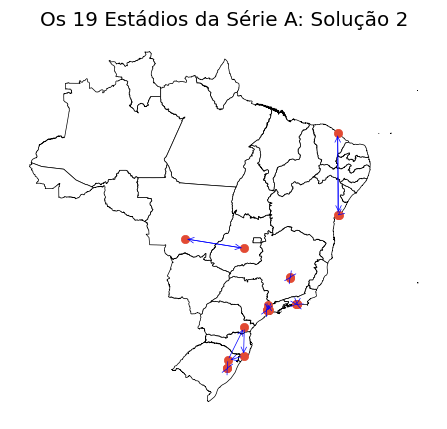

In [212]:
f, ax = plt.subplots(figsize=(8, 5))

ax.set_axis_off()
geo_plot.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(df.longitude, df.latitude)

arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in rota:
    plt.annotate("", xy=[ df.iloc[j]['longitude'], df.iloc[j]['latitude']],\
                      xytext=[ df.iloc[i]['longitude'], df.iloc[i]['latitude']],\
                     arrowprops=arrowprops)
    
plt.title("Os 19 Estádios da Série A: Solução 2")
plt.show()

Nesse caso, ainda há subrotas. Apesar da restrição ter "quebrado" a subrota anterior, agora a Ligga Arena forma uma subrota com o Majestoso e o Alfredo Jaconi.

Novamente adiciona-se uma restrição que impeça essa subrota de acontecer:

$x_{12,\!16}+x_{\!16, 12} + x_{12,\!15}+x_{\!15, 12} + x_{16,\!15}+x_{\!15, 16} <= 2$

Nesse caso, essa restrição garante que somente 2 desses caminhos serão tomados e, consequentemente, não será possível fechar um "triângulo" entre eles. Novamente, estamos exigindo que essa "subrota" se desmanche ou abranja mais estádios:

In [213]:
# Adiciona restrião que impede subrota entre Ligga Arena e Majestoso (basicamente obriga os dois a se socializarem)
model.addConstr(x[12, 16]+x[16, 12]+x[12, 15]+x[15, 12]+x[16, 15]+x[15, 16] <= 2)

# Otimiza!
model.optimize()

Vizualizando nossas novas rotas:

In [214]:
rota = [(i, j) for i in range(n) for j in range(n) if x[i, j].x == 1]

for i, j in rota: 
    print(f"{df.iloc[i, 0]} -> {df.iloc[j, 0]}")

Maracanã -> Nilton Santos
Morumbis -> Allianz Arena
Mineirão -> Arena MRV
Arena Grêmio -> Beira-Rio
Castelão -> Arena Fonte Nova
Beira-Rio -> Arena Grêmio
Neo-Quimica Arena -> Arena Red bull
Arena Fonte Nova -> Barradão
Nilton Santos -> São Januário
Arena MRV -> Mineirão
Allianz Arena -> Ligga Arena
Arena Pantanal -> Antonio Accioly
Ligga Arena -> Morumbis
Barradão -> Castelão
São Januário -> Maracanã
Alfredo Jaconi -> Majestoso
Majestoso -> Alfredo Jaconi
Arena Red bull -> Neo-Quimica Arena
Antonio Accioly -> Arena Pantanal


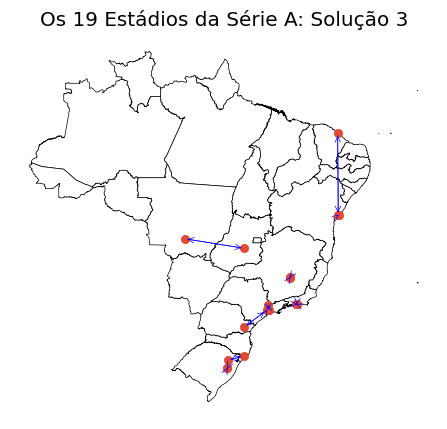

In [215]:
f, ax = plt.subplots(figsize=(8, 5))

ax.set_axis_off()
geo_plot.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(df.longitude, df.latitude)

arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in rota:
    plt.annotate("", xy=[ df.iloc[j]['longitude'], df.iloc[j]['latitude']],\
               xytext=[ df.iloc[i]['longitude'], df.iloc[i]['latitude']],\
                     arrowprops=arrowprops)
    
plt.title("Os 19 Estádios da Série A: Solução 3")
plt.show()

Nesse caso, a Ligga Arena se conectou ao Morumbi, legal, maaas... o Majestoso e Alfredo Jaconi fizeram uma nova subrota entre eles... A solução para isso é, sim, novamente adicionar novas restrições. Mas calma que eu não vou te alugar por mais tanto tempo. 

A idéia do Método é, basicamente, a cada iteração ir adicionando restrições. No nosso caso atacamos somente uma subrota, a que prendia os estádios do Paraná e Santa Catarina. Mas pode-se escalar isso e, sempre que rodar o modelo, definir uma função que encontra onde estão as subrotas para definir as novas restrições e, por fim, rodar o modelo novamente. 

O processo basicamente é:

1 - Definir onde estão as subrotas <br>
2 - Criar uma restrição de forma que a soma das variáveis $x_ij$, que serão combinações duas a duas dos n estádios dentro da subrota, seja menor ou igual que n - 1 <br>
3 - Rodar o modelo novamente <br>

Até que não haja mais subrotas.

Definindo uma função que encontre subrotas:

In [216]:
def encontra_subtours(rota):
    pontos = []
    for i,j in rota:
         if i not in pontos:
              pontos.append(i)
         if j not in pontos:
              pontos.append(j)
    n = len(pontos)
    
    visitados = [False] * n 
    subtours = [] 

    for inicio in range(n): 
        if not visitados[inicio]: 
            tour_atual = [] 
            i = inicio 
            
            while not visitados[i]: 
                visitados[i] = True 
                tour_atual.append(i) 
                proximo_ponto = None 
                for j in range(n): 
                    if (i, j) in rota and not visitados[j]: 
                            proximo_ponto = j 
                            break 
                if proximo_ponto is None: 
                    break 
                i = proximo_ponto 
                
            subtours.append(tour_atual) 
    return subtours

Loop onde fazemos inúmeras iterações até não termos mais subrotas:

In [217]:
# Criação do modelo 
model = gp.Model("TSP_Iterativo") 
model.Params.LogToConsole = 0

# Criação das variáveis de decisão 
x = model.addVars(n, n, vtype=GRB.BINARY, name="x") 

# Função objetivo 
model.setObjective(gp.quicksum(df_distancia.iloc[i,j] * x[i, j] for i in range(n) for j in range(n)), GRB.MINIMIZE) 

# Garante que o caixeiro vai se movimentar de um ponto para outro
for i in range(n):
    model.addConstr(gp.quicksum(x[i, j] for j in range(n)) == 1)

# Garante que partindo de um ponto, o caxeiro só chegará em outro ponto
for j in range(n):     
    model.addConstr(gp.quicksum(x[i, j] for i in range(n)) == 1)

# Garante que não ficará no mesmo lugar (o custo é zero, o que é bem tentador)
for i in range(n):     
    model.addConstr(x[i, i] == 0)

# Iteração para resolver o problema e cortar subrotas 

conjunto_rotas = []
iteracao = 0 
restricoes = []
while True: 
    iteracao += 1 

    # Resolver o modelo 
    model.optimize() 
    restricoes.append(len(model.getConstrs()))

    # Verificar se o modelo foi resolvido de forma ótima 
    if model.status != GRB.OPTIMAL: 
         print("Não foi possível encontrar uma solução ótima.") 
         break 

    rota = [(i, j) for i in range(n) for j in range(n) if x[i, j].x == 1]
    
    conjunto_rotas.append(rota)
    # Encontrar subrotas na solução 
    subtours = encontra_subtours(rota) 

    # Se não há subrotas, terminar o processo 
    if len(subtours) == 1: 
        break 
    
    # Adicionar restrições para eliminar as subrotas encontradas 

    for subtour in subtours: 
        if len(subtour) < n: 
            model.addConstr(gp.quicksum(x[i, j] for i in subtour for j in subtour if i != j) <= len(subtour) - 1) 
            

Vizualizando a rota definida pelo modelo:

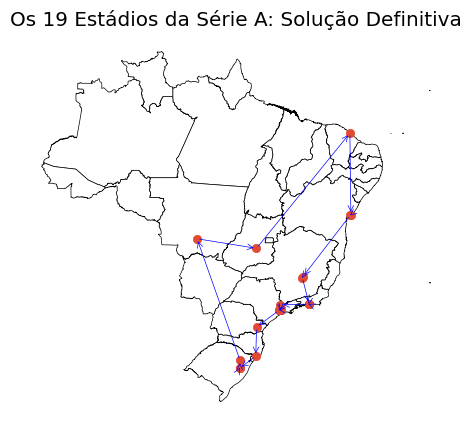

In [223]:
f, ax = plt.subplots(figsize=(8, 5))

ax.set_axis_off()
geo_plot.plot(ax=ax, color='white', edgecolor='black')
plt.scatter(df.longitude, df.latitude)

arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in rota:
    plt.annotate("", xy=[ df.iloc[j]['longitude'], df.iloc[j]['latitude']],\
                      xytext=[ df.iloc[i]['longitude'], df.iloc[i]['latitude']],\
                     arrowprops=arrowprops)
    
plt.title("Os 19 Estádios da Série A: Solução Definitiva")
plt.show()

Enfim, uma rota que reduz a distância percorrida, mas garante que todos os estados estarão conectados. Problema resolvido! 

Vizualizando a evolução das rotas:

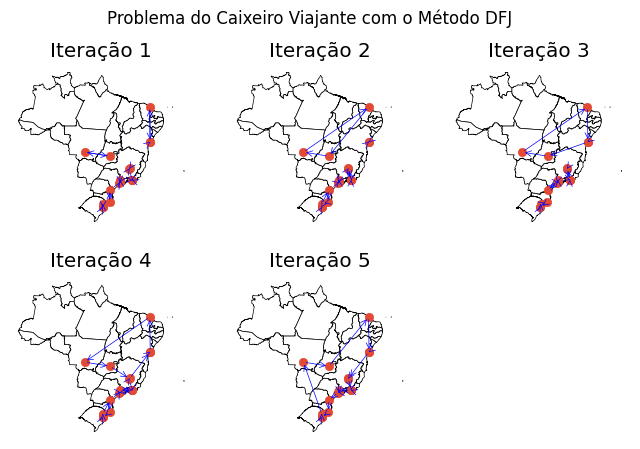

In [227]:
def plot_ax(ax, n, df):
    ax.set_axis_off()
    geo_plot.plot(ax=ax, color='white', edgecolor='black')
    ax.scatter(df.longitude, df.latitude)
    arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
    for i, j in conjunto_rotas[n]:
        ax.annotate("", xy=[df.iloc[j]['longitude'], df.iloc[j]['latitude']],\
                         xytext=[ df.iloc[i]['longitude'], df.iloc[i]['latitude']],\
                         arrowprops=arrowprops)
    ax.set_title(f"Iteração {n+1}")

f, axs = plt.subplots(figsize=(8,5), nrows=2, ncols=3)
axs = axs.ravel()

for n in range(5):
    plot_ax(axs[n], n, df)
axs[-1].remove()

plt.suptitle("Problema do Caixeiro Viajante com o Método DFJ")
plt.show()

Analisando o número de restrições adicionadas e o número de subrotas:

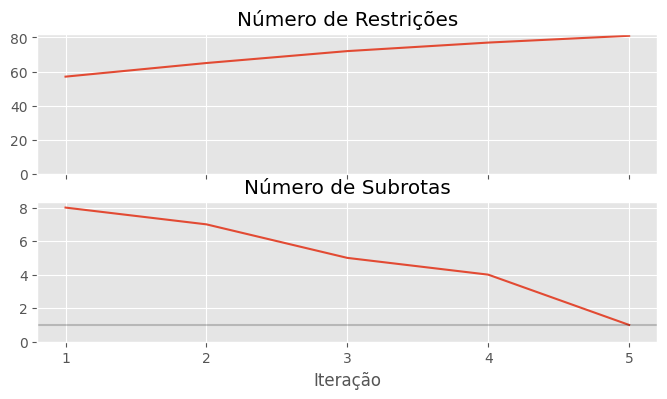

In [225]:
f, axs = plt.subplots(figsize=(8, 4), nrows=2, sharex=True)

axs[0].plot(range(1, 6), restricoes)
axs[0].set_ylim(0)
axs[0].set_title("Número de Restrições")

axs[1].plot(range(1, 6), [len(encontra_subtours(rota)) for rota in conjunto_rotas])
axs[1].set_ylim(0)
axs[1].set_title("Número de Subrotas")
axs[1].set_xticks(range(1, 6))
axs[1].set_xlabel("Iteração")
axs[1].axhline(y=1, color="k", alpha=.2)

plt.show()

Nesse caso é interessante como foi definida somente 81 restrições para a resolução do problema, com pouco mais de 20 restrições para evitar as subrotas deste conjunto de dados, o que é bem abaixo das centenas de milhares de restrições necessárias para todas as possíveis subrotas. Isso acontece porque é praticamente impossível, por exemplo, o Beira Rio (no Rio Grande do Sul) formar uma subrota com o Castelão (no Ceará). Nesse caso, então, ao inves do nosso algoritmo se preocupar com as centenas de milhares de subrotas improváveis, ele foca em evitar as subrotas factíveis, por exemplo:

É provável que estádios do mesmo estado formem uma subrota (iteração 1). O modelo adiciona restrições para isso. Depois, é provável que, não podendo ficar restrito ao próprio estado, estádios de mesma região formem subrotas (iteração 4). O modelo adiciona restrições para isso. Dessa forma, o modelo vai obrigando as subrotas a se integrarem, de forma que em 5 iterações (para esse conjunto de pontos), chegue a uma solução ótima e integrada.